# Supervised image denoising

## Import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm.notebook import tqdm
import os


## Load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_07_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

original_train = data['original_train'] 
noise_train    = data['noise_train']

original_test = data['original_test'] 
noise_test    = data['noise_test']

print('*************************************************')
print('size of original_train : ', original_train.shape)
print('size of noise_train    : ', noise_train.shape)
print('*************************************************')
print('size of original_test : ', original_test.shape)
print('size of noise_test    : ', noise_test.shape)
print('*************************************************')
print('number of training image :', original_train.shape[0])
print('height of training image :', original_train.shape[1])
print('width of training image  :', original_train.shape[2])
print('*************************************************')
print('number of testing image :', original_test.shape[0])
print('height of testing image :', original_test.shape[1])
print('width of testing image  :', original_test.shape[2])
print('*************************************************')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
*************************************************
size of original_train :  (2000, 64, 64)
size of noise_train    :  (2000, 64, 64)
*************************************************
size of original_test :  (900, 64, 64)
size of noise_test    :  (900, 64, 64)
*************************************************
number of training image : 2000
height of training image : 64
width of training image  : 64
*************************************************
number of testing image : 900
height of testing image : 64
width of testing image  : 64
*************************************************


## Hyper parameters

In [3]:
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 100
size_minibatch  = 32
learning_rate   = 0.01
momentum        = 0.01
weight_decay    = 0.0001

## Costumize dataloader for pytorch

In [4]:
class dataset (Dataset):
  def  __init__(self, original,noise):

    self.original = original
    self.noise    = noise
        
  def __getitem__(self, index):

    original    = self.original[index]
    noise       = self.noise[index]
    
    original   = torch.FloatTensor(original).unsqueeze(dim=0)
    noise      = torch.FloatTensor(noise).unsqueeze(dim=0)


    return (original , noise)
  
  def __len__(self):

     return self.original.shape[0]
     

## Construct datasets and dataloaders for training and testing

In [5]:
dataset_train = dataset(original_train, noise_train) 
dataset_test  = dataset(original_test, noise_test) 

dataloader_train = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, num_workers=2)
dataloader_test  = DataLoader(dataset_test,  batch_size=size_minibatch, shuffle=False, drop_last=True, num_workers=2) 

## Shape of the data with data loader

In [6]:
(original_train, noise_train)   = dataset_train[0]
(original_test, noise_test)     = dataset_test[0]

print('************************************************************')
print('shape of the original image in the training dataset:', original_train.shape)
print('shape of the noisy image in the training dataset:', noise_train.shape)
print('************************************************************')
print('shape of the original image in the testing dataset:', original_test.shape)
print('shape of the noisy image in the testing dataset:', noise_test.shape)
print('************************************************************')

************************************************************
shape of the original image in the training dataset: torch.Size([1, 64, 64])
shape of the noisy image in the training dataset: torch.Size([1, 64, 64])
************************************************************
shape of the original image in the testing dataset: torch.Size([1, 64, 64])
shape of the noisy image in the testing dataset: torch.Size([1, 64, 64])
************************************************************


## Class for the neural network

In [7]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(
            self,
            in_channels,
            n_filters,
            k_size,
            stride,
            padding,
            bias=True,
            dilation=1,
            with_bn=True,
    ):
        super(conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(int(in_channels),
                             int(n_filters),
                             kernel_size=k_size,
                             padding=padding,
                             stride=stride,
                             bias=bias,
                             dilation=dilation, )

        if with_bn:
            self.cbr_unit = nn.Sequential(conv_mod,
                                          nn.BatchNorm2d(int(n_filters)),
                                          nn.ReLU(inplace=True))
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs


class SegNet(nn.Module):
    def __init__(self, n_classes=1, in_channels=1, is_unpooling=True):
        super(SegNet, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling

        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)

        up5 = self.up5(down5, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)

        return up1

    def init_vgg16_params(self, vgg16):
        blocks = [self.down1, self.down2, self.down3, self.down4, self.down5]

        ranges = [[0, 4], [5, 9], [10, 16], [17, 23], [24, 29]]
        features = list(vgg16.features.children())

        vgg_layers = []
        for _layer in features:
            if isinstance(_layer, nn.Conv2d):
                vgg_layers.append(_layer)

        merged_layers = []
        for idx, conv_block in enumerate(blocks):
            if idx < 2:
                units = [conv_block.conv1.cbr_unit, conv_block.conv2.cbr_unit]
            else:
                units = [
                    conv_block.conv1.cbr_unit,
                    conv_block.conv2.cbr_unit,
                    conv_block.conv3.cbr_unit,
                ]
            for _unit in units:
                for _layer in _unit:
                    if isinstance(_layer, nn.Conv2d):
                        merged_layers.append(_layer)

        assert len(vgg_layers) == len(merged_layers)

        for l1, l2 in zip(vgg_layers, merged_layers):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data

## Build the network

In [9]:
model = SegNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum , weight_decay=weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Compute prediction (denoised image)

In [10]:
def compute_prediction(model, input):

    denoise = model(input)

    return denoise

## Compute loss

In [11]:
def compute_loss(noise, original):

    criterion   = nn.MSELoss()
    loss        = criterion(noise, original)
    loss_value  = loss.item()

    return loss, loss_value

## Compute PSNR metric

In [12]:
def compute_PSNR (loss):

  if (loss==0.):
    PSNR=100
  else :
    PSNR=10*log10(1/loss)

  return PSNR

## Variable for the learning curves

In [13]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
PSNR_mean_train     = np.zeros(number_epoch)
PSNR_std_train      = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
PSNR_mean_test      = np.zeros(number_epoch)
PSNR_std_test       = np.zeros(number_epoch)

## Train

In [14]:
def train(model, dataloader):

    loss_epoch      = []
    psnr_epoch      = []

    model.train()
    mdoel = model.to(device)

    for index_batch, (original, noise) in enumerate(dataloader):

        original = original.to(device)
        noise = noise.to(device)
        
        x_noisy_train = (original + noise)
        x_noisy_train = x_noisy_train.to(device)
        # ================================================================================ 
        # complete the following codes 
        # 
        denoise             = compute_prediction(model, x_noisy_train)
        loss, loss_value    = compute_loss(denoise, original)
        # ================================================================================ 
        psnr                = compute_PSNR(loss_value)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        psnr_epoch.append(psnr)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    psnr_mean_epoch = np.mean(psnr_epoch)
    psnr_std_epoch  = np.std(psnr_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    psnr        = {'mean' : psnr_mean_epoch, 'std' : psnr_std_epoch}

    return (loss, psnr)    


## Test

In [15]:
def test(model, dataloader):

    loss_epoch      = []
    psnr_epoch      = []

    model.eval()
    mdoel = model.to(device)

    for index_batch, (original, noise) in enumerate(dataloader):

        original = original.to(device)
        noise = noise.to(device)

        x_noisy_test = (original + noise)
        x_noisy_test = x_noisy_test.to(device)
        
        # ================================================================================ 
        # complete the following codes 
        # 
        denoise             = compute_prediction(model, x_noisy_test)
        loss, loss_value    = compute_loss(denoise, original)
        # ================================================================================ 
        psnr                = compute_PSNR(loss_value)
        # print(loss, psnr)

        loss_epoch.append(loss_value)
        psnr_epoch.append(psnr)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    psnr_mean_epoch = np.mean(psnr_epoch)
    psnr_std_epoch  = np.std(psnr_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    psnr        = {'mean' : psnr_mean_epoch, 'std' : psnr_std_epoch}

    return (loss, psnr)    

## train and test

In [16]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
model = model.to(device)

for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, psnr_train) = train(model, dataloader_train)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    PSNR_mean_train[i]  = psnr_train['mean']
    PSNR_std_train[i]   = psnr_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, psnr_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    PSNR_mean_test[i]  = psnr_test['mean']
    PSNR_std_test[i]   = psnr_test['std']

    print(f"epoch : {i}, train psnr : {psnr_train['mean']}, test psnr : {psnr_test['mean']}")

epoch : 55, train psnr : 17.84793015364051, test psnr : 18.040613530159238
epoch : 56, train psnr : 17.92065967449524, test psnr : 17.864374534998955
epoch : 57, train psnr : 18.032479527204607, test psnr : 18.13762989793803
epoch : 58, train psnr : 18.039409710548224, test psnr : 18.254346764150036
epoch : 59, train psnr : 17.992256382557578, test psnr : 18.083055593692023
epoch : 60, train psnr : 18.11000231242215, test psnr : 18.4563496643498
epoch : 61, train psnr : 18.237692423772774, test psnr : 18.279008531381216
epoch : 62, train psnr : 18.19198753712707, test psnr : 18.06111803614679
epoch : 63, train psnr : 18.203858388124367, test psnr : 18.16844306774723
epoch : 64, train psnr : 18.207145778383683, test psnr : 18.29955623152949
epoch : 65, train psnr : 18.41472856272048, test psnr : 18.487777612729676
epoch : 66, train psnr : 18.157990460848026, test psnr : 18.665097180729248
epoch : 67, train psnr : 18.283408852527828, test psnr : 18.812925800324333
epoch : 68, train psnr 

---

# DO NOT MODIFY THE CODES FROM HERE, BUT EXECUTE THEM

---

## Plot functions

In [17]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * 3, nRow * 3))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [18]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * 3, nRow * 3))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [19]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [20]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [21]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [22]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [23]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [24]:
def function_result_01():

    print('[plot examples of the training clean images]')
    print('') 

    nRow = 5 
    nCol = 4
    index_data  = np.arange(0, nRow * nCol)
    original_train = dataset_train.original[index_data]

    plot_data_grid(original_train, index_data, nRow, nCol)

In [25]:
def function_result_02():

    print('[plot examples of the training noisy images]')
    print('') 
    
    nRow = 5
    nCol = 4
    index_data  = np.arange(0, nRow * nCol)
    noise_train = dataset_train.noise[index_data]

    plot_data_grid(noise_train, index_data, nRow, nCol)

In [26]:
def function_result_03():

    print('[plot examples of the training denoising results]')
    print('') 

    nRow = 5
    nCol = 4
    index_data          = np.arange(0, nRow * nCol)
    image_train         = torch.FloatTensor(dataset_train.original[index_data]).unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, image_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [27]:
def function_result_04():

    print('[plot examples of the testing clean images]')
    print('') 
    
    nRow = 5
    nCol = 4
    index_data = np.arange(0, nRow * nCol)
    original_test = dataset_test.original[index_data]

    plot_data_grid(original_test, index_data, nRow, nCol)

In [28]:
def function_result_05():

    print('[plot examples of the testing noise images]')
    print('') 

    nRow = 5
    nCol = 4
    index_data = np.arange(0, nRow * nCol)
    noise_test = dataset_test.noise[index_data]

    plot_data_grid(noise_test, index_data, nRow, nCol)

In [29]:
def function_result_06():

    print('[plot examples of the testing denoising results]')
    print('') 

    nRow = 5
    nCol = 4
    index_data      = np.arange(0, nRow * nCol)
    image_test      = torch.FloatTensor(dataset_test.original[index_data]).unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, image_test)

    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [30]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [31]:
def function_result_08():

    print('[plot the training PSNR]')
    print('') 
    
    plot_curve_error(PSNR_mean_train, PSNR_std_train, 'epoch', 'PSNR', 'PSNR (training)')

In [32]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [33]:
def function_result_10():
    
    print('[plot the testing PSNR]') 
    print('') 
    
    plot_curve_error(PSNR_mean_test, PSNR_std_test, 'epoch', 'PSNR', 'PSNR (testing)')

In [34]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [35]:
def function_result_12():
    
    print('[print the training PSNR at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(PSNR_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [36]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [37]:
def function_result_14():
    
    print('[print the testing PSNR at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(PSNR_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [38]:
def function_result_15():
    
    print('[print the best training PSNR within the last 10 epochs]')
    print('') 

    value = get_max_last_range(PSNR_mean_train, -10)
    print('best training PSNR = %12.10f' % (value))

In [39]:
def function_result_16():
    
    print('[print the best testing PSNR within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(PSNR_mean_test, -10)
    print('best testing PSNR = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training clean images]



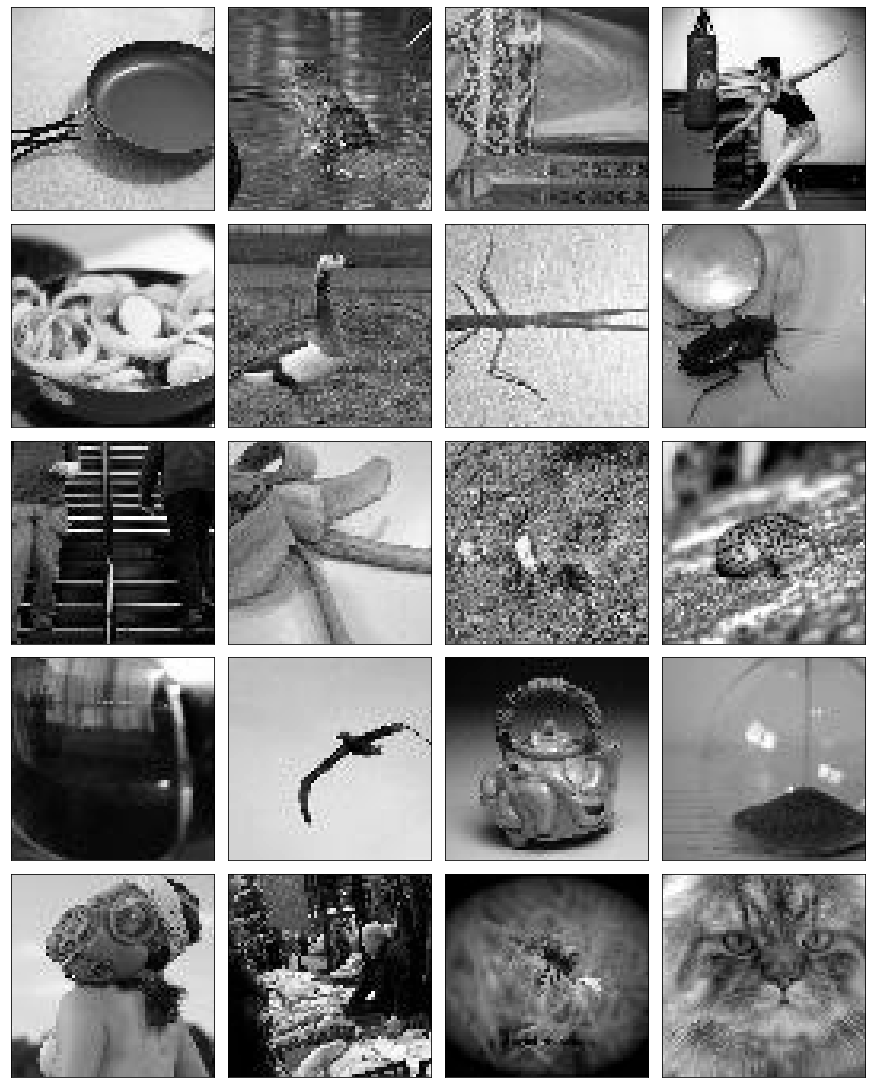


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training noisy images]



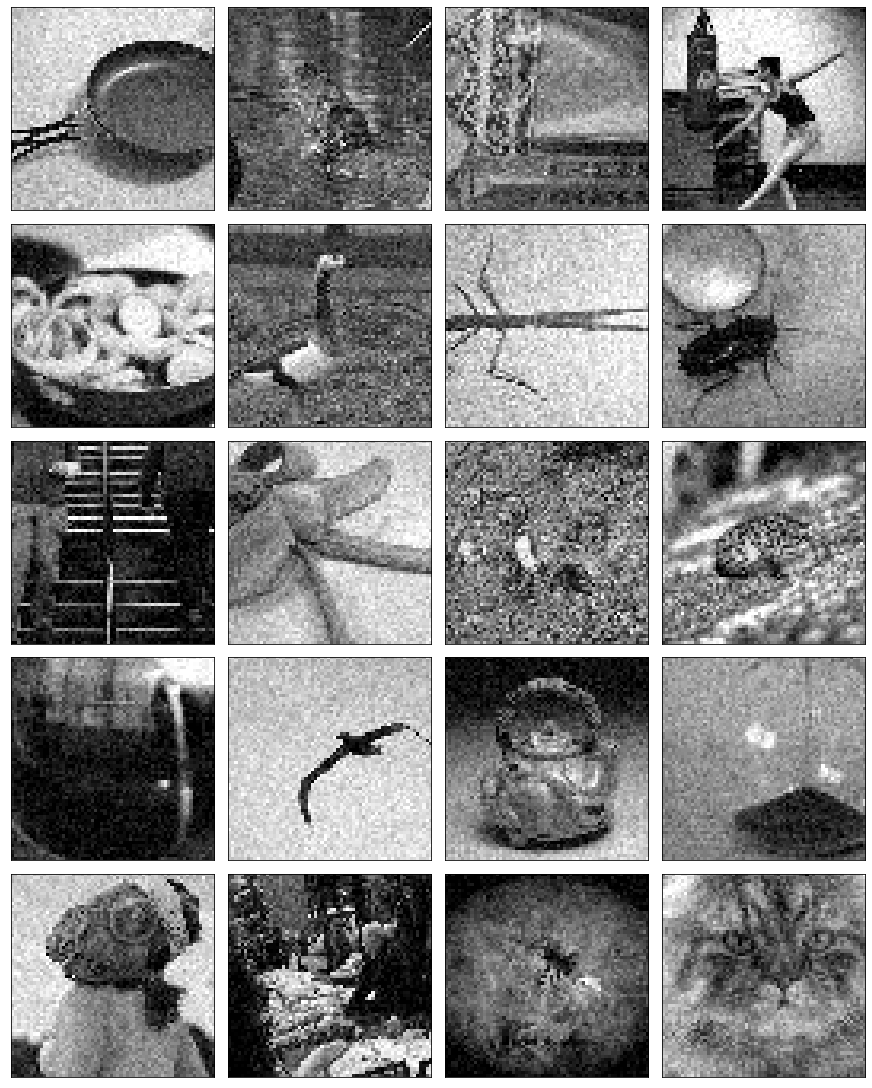


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training denoising results]



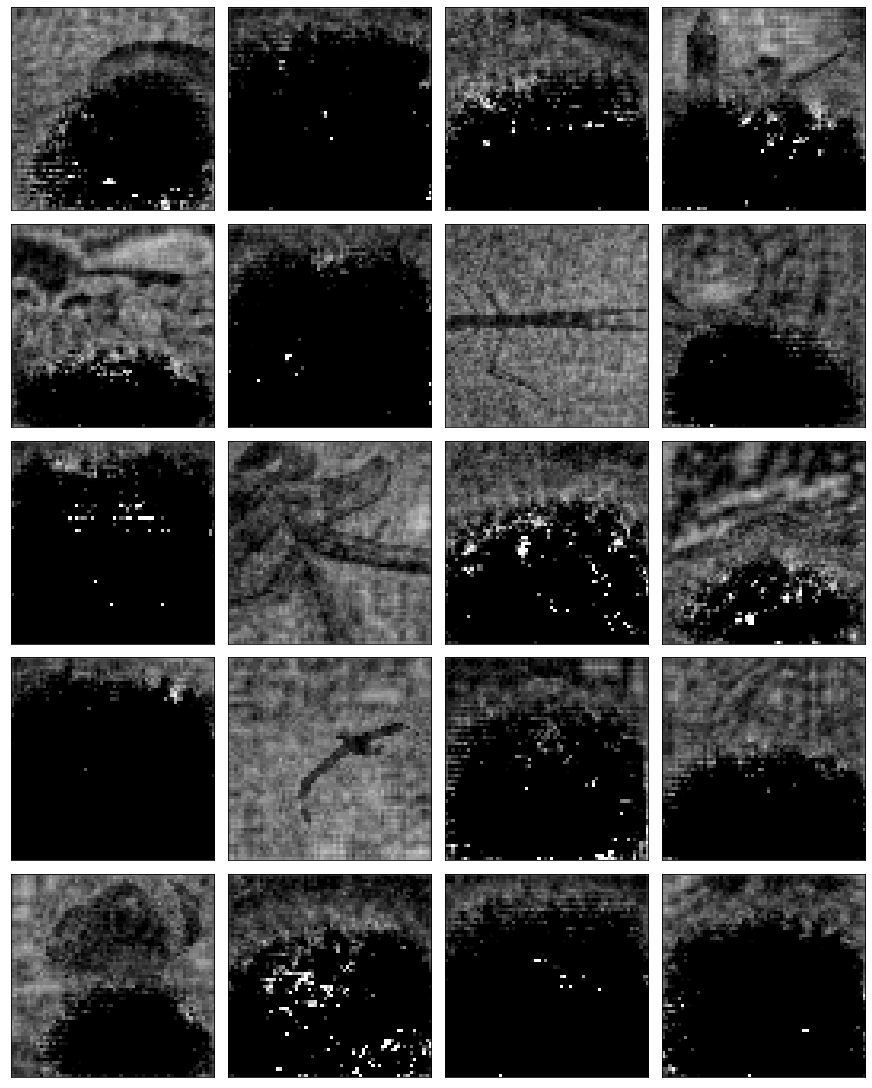


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing clean images]



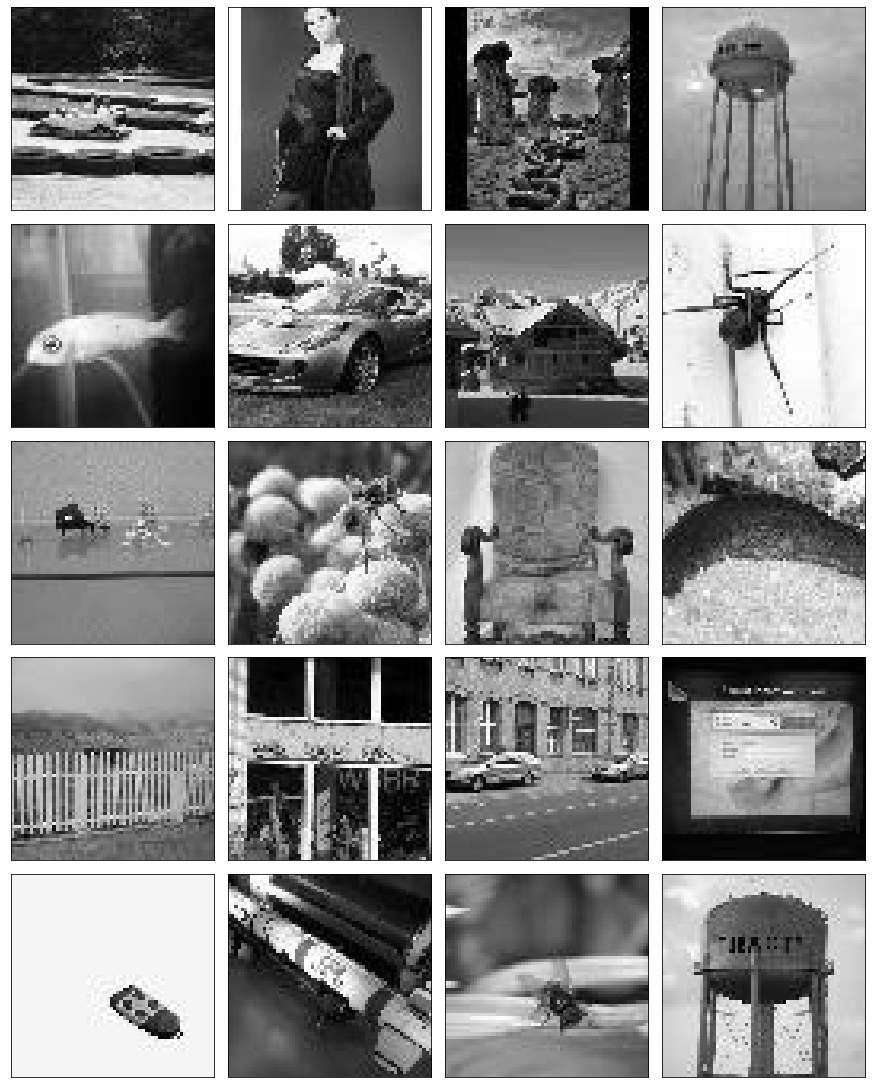


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing noise images]



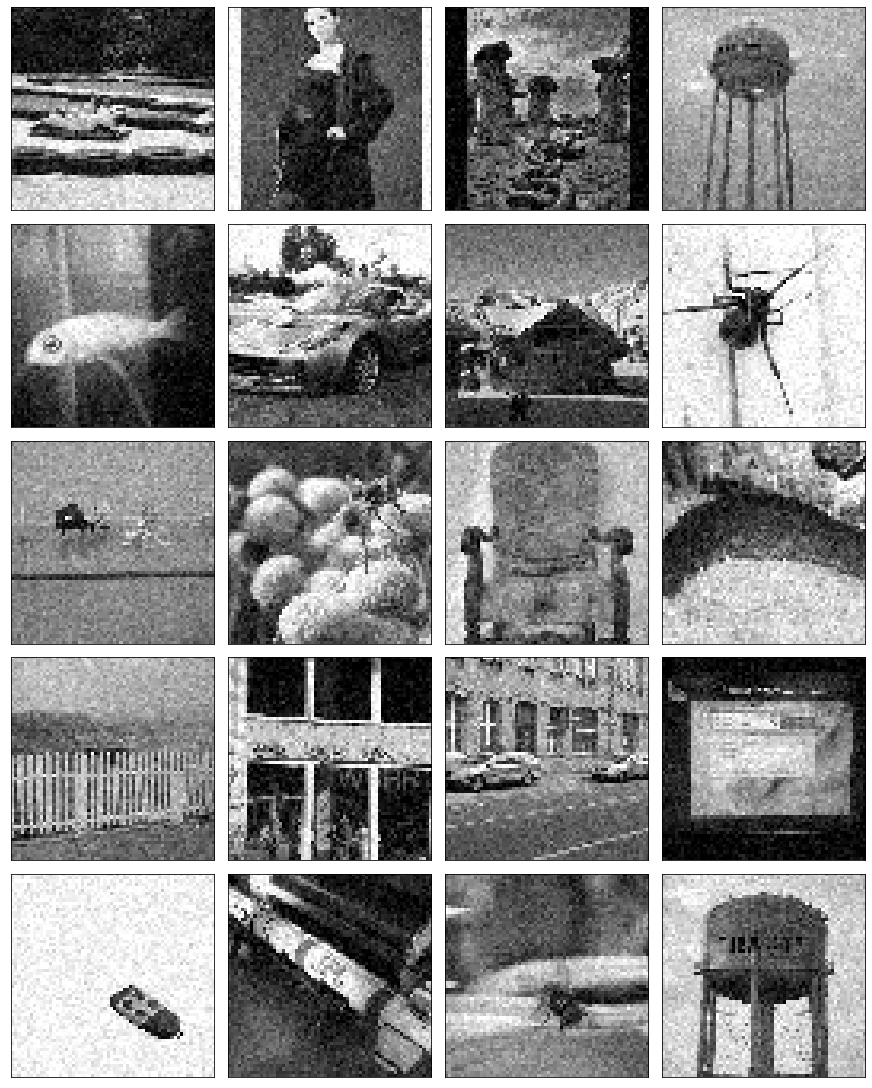


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing denoising results]



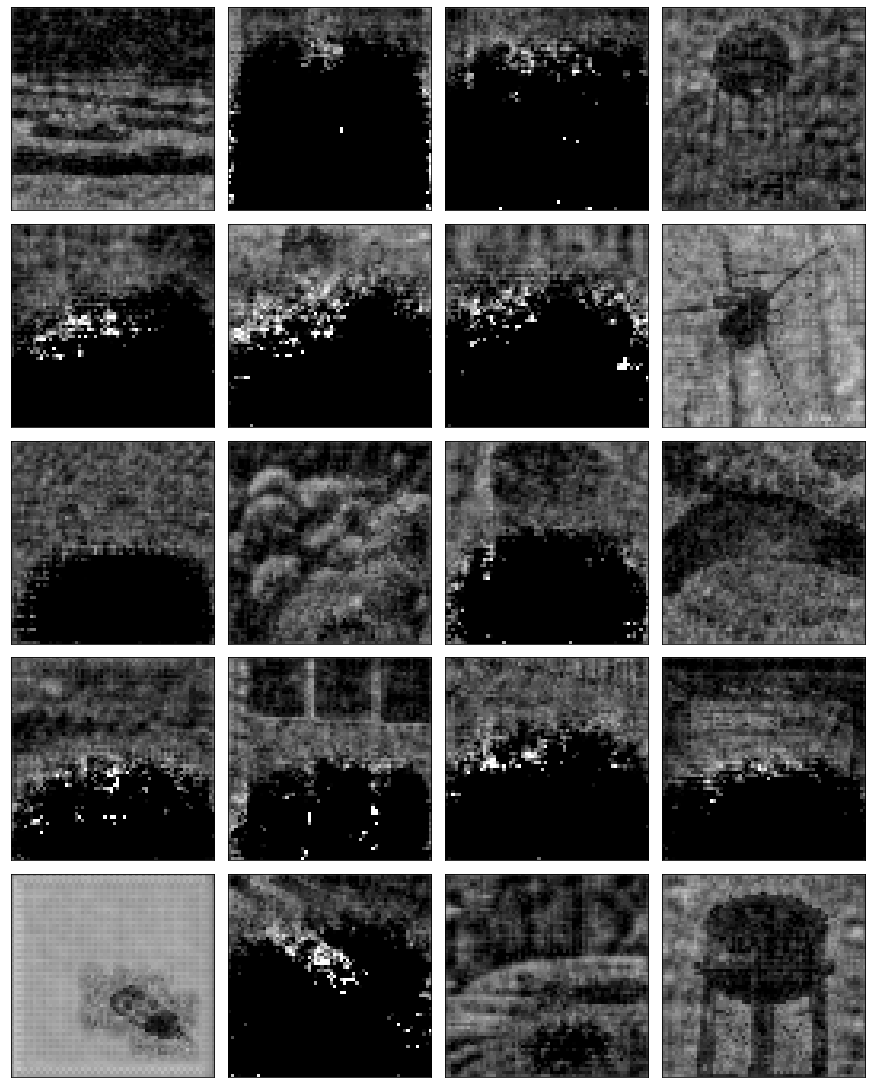


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



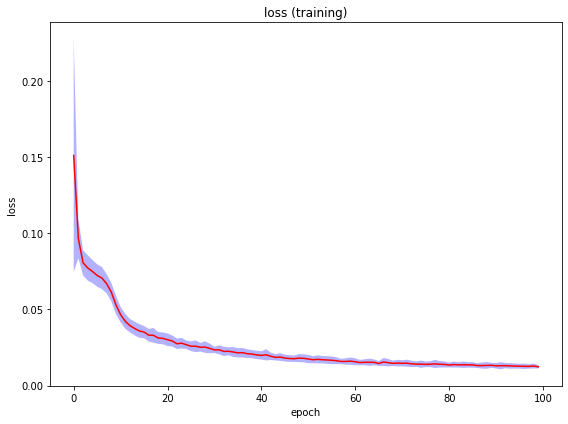


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training PSNR]



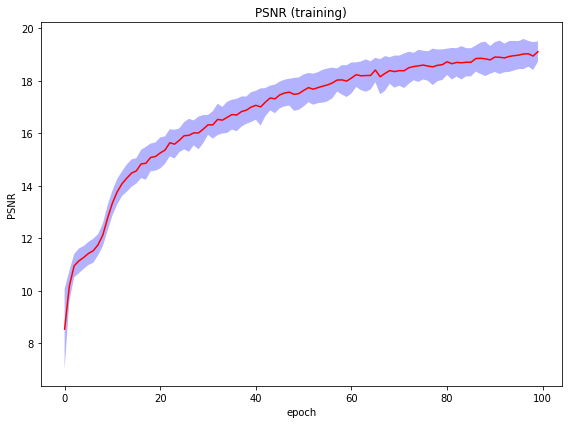


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



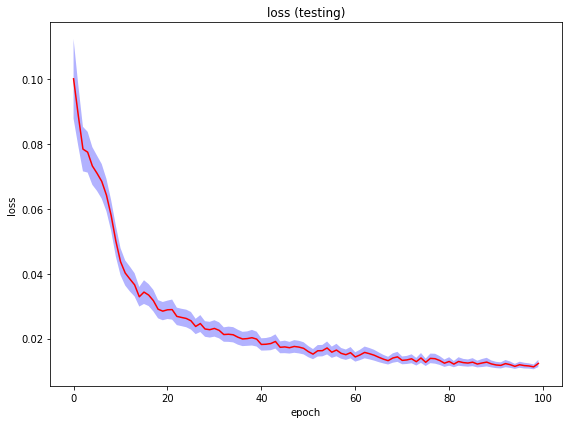


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing PSNR]



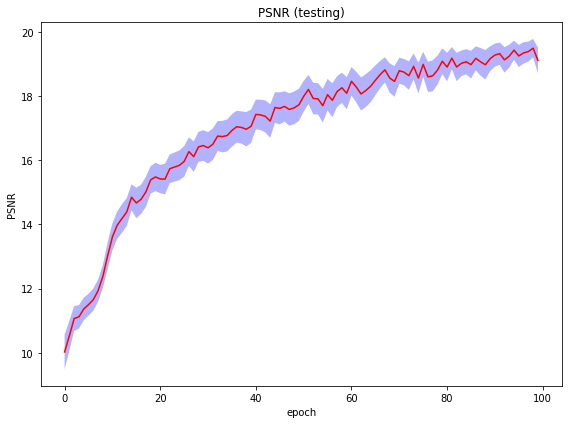


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.0129711076
index =  1, value = 0.0130390979
index =  2, value = 0.0130617074
index =  3, value = 0.0129098963
index =  4, value = 0.0128111981
index =  5, value = 0.0127365753
index =  6, value = 0.0126288502
index =  7, value = 0.0125804871
index =  8, value = 0.0128403652
index =  9, value = 0.0123153555

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training PSNR at the last 10 epochs]

index =  0, value = 18.9083349459
index =  1, value = 18.9003976232
index =  2, value = 18.8750287833
index =  3, value = 18.9319273632
index =  4, value = 18.9605591867
index =  5, value = 18.9828726168
inde

In [40]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)